In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import json
import matplotlib.pyplot as plt

In [2]:
# Paths
DATA_DIR = 'data/plantvillage_subset'  # Use your subset directory
MODEL_PATH = 'models/disease_mobilenetv2.h5'
CLASS_NAMES_PATH = 'models/disease_class_names.json'

In [9]:
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10  # Increase for better accuracy

In [10]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 13363 images belonging to 17 classes.
Found 2349 images belonging to 17 classes.


In [11]:
# Save class names for inference
class_names = list(train_gen.class_indices.keys())
os.makedirs('models', exist_ok=True)
with open(CLASS_NAMES_PATH, 'w') as f:
    json.dump(class_names, f)

In [12]:
# Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Fine-tune later if needed

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.5853 - loss: 1.3861 - val_accuracy: 0.9229 - val_loss: 0.2815
Epoch 2/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.9102 - loss: 0.2985 - val_accuracy: 0.9468 - val_loss: 0.1918
Epoch 3/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.9379 - loss: 0.2086 - val_accuracy: 0.9553 - val_loss: 0.1574
Epoch 4/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 931s 2s/step - accuracy: 0.9444 - loss: 0.1798 - val_accuracy: 0.9570 - val_loss: 0.1402
Epoch 5/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.9497 - loss: 0.1529 - val_accuracy: 0.9583 - val_loss: 0.1384
Epoch 6/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.9537 - loss: 0.1424 - val_accuracy: 0.9621 - val_loss: 0.1171
Epoch 7/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.9547 - loss: 0.1353 - val_accuracy: 0.9625 - val_loss: 0.1065
Epoch 8/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.9570 - loss: 0.1215 - val_accu

In [15]:
# Save model
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to models/disease_mobilenetv2.h5


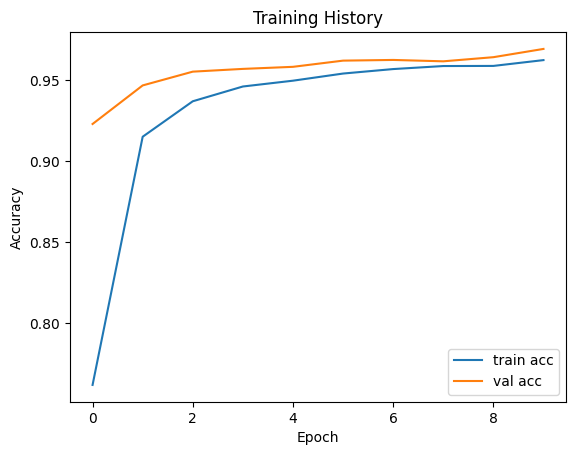

In [16]:
# Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show() 

In [17]:
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final validation accuracy: {final_val_acc:.4f}")

Final validation accuracy: 0.9693
